# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Análisis por Predicción Lineal</center>      

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

from scipy.linalg import toeplitz
from scipy.linalg import solve

import IPython.display as ipd

**NOTA:** *Las siguientes dos celdas solo son necesarias para descargar el archivo de ejemplo. Ignórelas si va a trabajar con sus propios archivos de audio.*

In [2]:
!pip install wget

In [3]:
import wget

### Cómo correr el notebook
Se puede bajar y correr el notebook de forma local en una computadora.

O también se puede correr en Google Colab usando el siguiente enlace. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/notebooks/audioDSP-LPC_analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Descripción

Este ejercicio sirve de introducción al **análisis por predicción lineal**. Se implementa análisis por el método de **autocorrelación**. Se calculan los coeficientes del modelo, el error y la ganancia.

El análisis LPC extrae los parámetros del modelo de producción de voz a partir del análisis de un fragmento de tiempo corto de la señal de voz. Se plantea un modelo todo polos de la forma,

$$ H(z) = \frac{S(z)}{U(z)} = \frac{G}{1-\sum_{k=1}^{p}a_kz^{-k}}$$
$$ s[n] = \sum_{k=1}^{p}a_k s[n-k]+Gu[n]. $$

Se define un predictor de orden $p$ a partir de las muestras pasadas de la salida,

$$\tilde{s}[n] = \sum_{k=1}^{p}\alpha_k s[n-k].$$

La solución consiste en obtener los coeficientes que minimizan el error cuadrático de predicción para un fragmento de tiempo corto de la señal de voz $s_n[m]$ elegido en torno a la muestra $n$, i.e. $s_n[m]=s[m+n]$. 

$$ \begin{align}\label{eq:mean_square_error}
		 E_n &= \sum_m e_n^2[m]\nonumber\\
		     &= \sum_m\left(s_n[m]-\tilde{s}_n[m]\right)^2\nonumber\\
		     &= \sum_m\left(s_n[m]-\sum_{k=1}^{p}\alpha_k s_n[m-k]\right)^2
		\end{align}      
$$
El análisis es de tiempo corto, por lo que el rango de la sumatoria es finito. Hay dos enfoques para resolver el problema que difieren en la elección de los límites de la sumatoria, el método de la **autocorrelación** y el método de la **covarianza**.

A continuación se carga la señal de audio que será procesada.

In [4]:
# download impulse responses as audio files
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/voice2.wav?raw=true')

100% [........................................................] 284464 / 284464

'voice2.wav'

In [5]:
# read the audio file
filename = 'voice2.wav'

# read audio samples using scipy.io.wavfile
fs, x = wavfile.read(filename)

# normalize maximum (absolute) amplitude
x = x / np.max(abs(x)) * 0.9

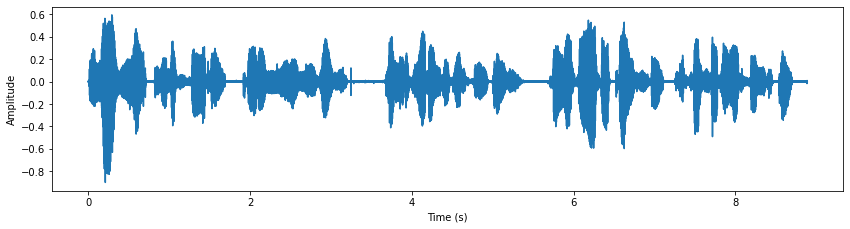

In [6]:
# time corresponding to the audio signal
time_x = np.arange(0, x.size)/fs

# plot the audio signal waveform
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(time_x, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.tight_layout()

In [7]:
ipd.Audio(x, rate=fs)

### Parte 1

En esta primera parte se extraer un frame de la señal de audio y se aplica una ventana suavizante. 

Luego de ejecutar el código responda las siguientes preguntas. 

1. ¿En el método de la autocorrelación que se asume sobre la señal fuera del intervalo de análisis?
2. ¿Qué efecto tiene este supuesto en la estimación LPC en los bordes de la trama de señal?
3. ¿Cuál es el objetivo de aplicar una ventana suavizante?


In [8]:
# number of samples in window
N = 460

# initial sample of the audio frame
ind_ini = 94567

# signal frame
s = x[ind_ini:ind_ini+N]

# smoothing window
window = signal.windows.get_window('hann', N)

# windowed signal frame
s_win = s * window

# number of DFT points
Ndft = 1024

# spectrum of the signal frame
X = np.fft.fft(s_win, Ndft)
# frequency values
f = np.fft.fftfreq(Ndft) * fs

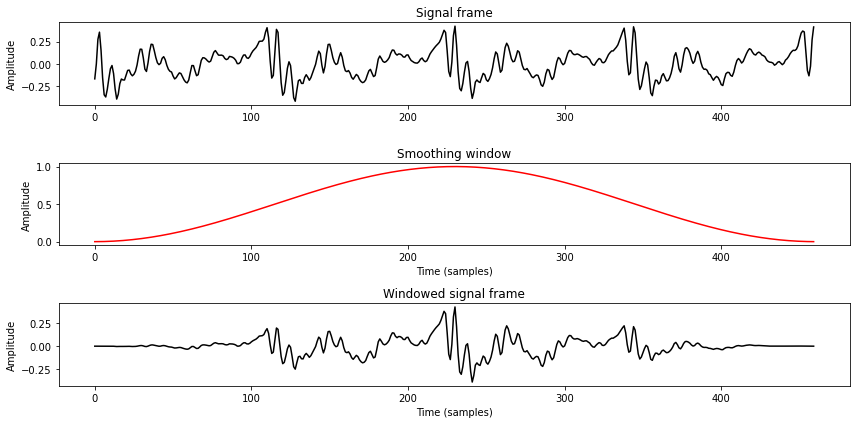

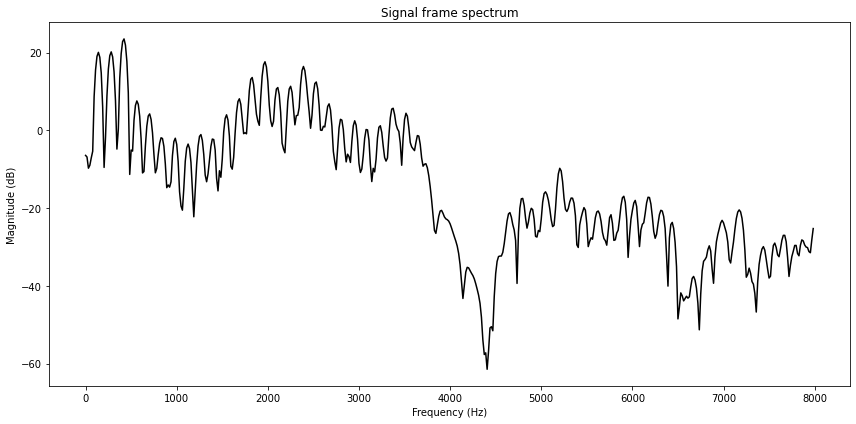

In [9]:
# plot the original signal frame
plt.figure(figsize=(12,6))
ax1 = plt.subplot(3, 1, 1)
plt.plot(s, 'k')
plt.ylabel('Amplitude')
plt.title('Signal frame')

# plot the smoothing window
ax2 = plt.subplot(3, 1, 2)
plt.plot(window, 'r')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Smoothing window')

# plot the windowed frame
ax3 = plt.subplot(3, 1, 3)
plt.plot(s_win, 'k')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Windowed signal frame')
plt.tight_layout()

# magnitude spectrum
magX = np.abs(X)
ind_fmx = int(Ndft/2)

# plot the frequency response
plt.figure(figsize=(12,6))
ax1 = plt.subplot()
ax1.set_title('Signal frame spectrum')
ax1.plot(f[:ind_fmx], 20 * np.log10(magX[:ind_fmx]), 'k')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Frequency (Hz)')
plt.tight_layout()


### Parte 2

El siguiente código implementa el **análisis LPC** usando el método de la **autocorrelación**. 

Tenga en cuenta que el sistema de ecuaciones expresado en forma matricial es el siguiente.


$$
		\left( \begin{array}{ccccc}
		R_n[0] & R_n[1] & R_n[2] & \cdots & R_n[p-1]\\
		R_n[1] & R_n[0] & R_n[1] & \cdots & R_n[p-2]\\
		R_n[2] & R_n[1] & R_n[0] & \cdots & R_n[p-3]\\
		\vdots & \vdots & \vdots & \ddots & \vdots\\
		R_n[p-1] & R_n[p-2] & R_n[p-3] & \cdots & R_n[0]\\
		\end{array} \right) \left( \begin{array}{c}
		\alpha_1\\
		\alpha_2\\
		\alpha_3\\
		\vdots\\
		\alpha_p\\
		\end{array} \right) = \left( \begin{array}{c}
		R_n[1]\\
		R_n[2]\\
		R_n[3]\\
		\vdots\\
		R_n[p]\\
		\end{array} \right)
$$

Y que el error cuadrático medio mínimo es:
  
$$E_n = R_n[0]-\sum_{k=1}^p\alpha_kR_n[k].$$


Complete el código que se proporciona a continuación. Para ello, siga los siguientes pasos. 

1. Calcular los valores de la autocorrelación que intervienen en el sistema de ecuaciones.
2. Plantear y resolver el sistema de ecuaciones, teniendo en cuenta que hay que invertir una matriz Toeplitz.
3. Calcular el valor mínimo del error cuadrático medio.


In [45]:
def lpc_analysis(s, p=20):
    """ compute the LPC analysis using the autocorrelation method
    
    Parameters
    ----------
    x : numpy array
        windowed signal frame as a numpy 1D array.
    p : int
        model order.
        
    Returns
    -------
    ak : numpy array
         model coefficients.
    e : float
        minimum mean squared error.
    e_norm : float
             normalized minimum mean squared error.
    """
    # frame length
    N = s.shape[0]
    
    # compute autocorrelation values
    r = np.zeros((p+1, 1))
    for k in range(p+1):
        r[k] = np.dot(s[:N-k].T, s[k:])

    # solve to compute model coefficients
    ak = solve(toeplitz(r[:p]), r[1:p+1]).squeeze()

    # compute mean squared error
    e = r[0] - ak @ r[1:p+1]

    # compute normalized mean squared error
    e_norm = e / r[0]

    return ak, e, e_norm

### Parte 3

Una vez completada la implementación de la función `lpc_analysis` siga los siguientes pasos para calcular la respuesta en frecuencia y la respuesta al impulso del sistema.

Tenga presente la forma de la función de transferencia del sistema

$$H(z) = \frac{S(z)}{U(z)} = \frac{G}{1-\sum_{k=1}^{p}\alpha_kz^{-k}}.$$
      
1. Ejecute la función `lpc_analysis` para la trama de audio. 
2. Calcule los polinomios numerador y denominador del filtro resultante.
3. Calcule la ganancia G a partir del error cuadrático medio.
4. Calcule la prespuesta al impulso filtrando una delta con el filtro resultante.
5. Cambie el orden del modelo y analice el resultado obtenido.

In [46]:
# model order
p = 26

# apply lpc analysis to signal frame
ak, e, e_norm = lpc_analysis(s_win, p)

# filter obtained from the lpc analysis
S = [1]
U = np.concatenate([[1], -ak])

# compute gain 
G = np.sqrt(e)

# compute the frequency response of the digital filter
w, H = signal.freqz(G*S, U, worN=Ndft, whole=True)
fw = w / (2 * np.pi) * fs

# impulse response of the LPC filter
delta = np.zeros(N)
delta[0] = 1
h = signal.lfilter(G*S, U, delta)

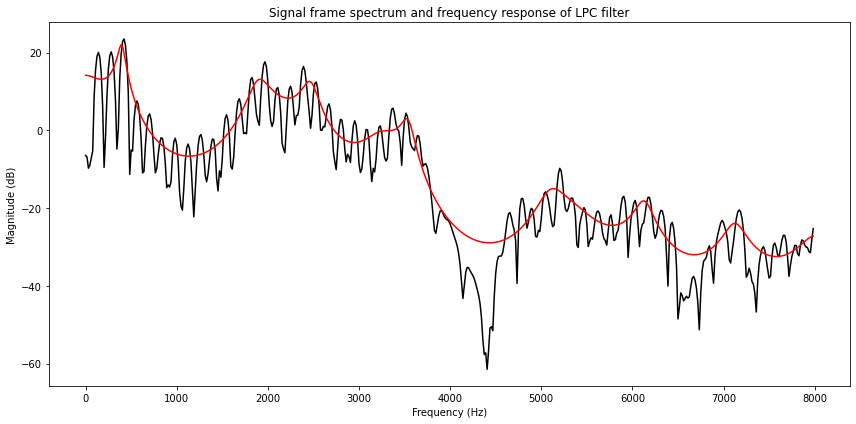

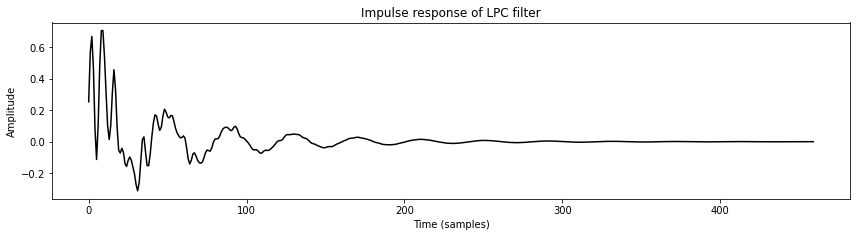

In [47]:
# magnitude spectrum
magH = np.abs(H)
ind_fmx = int(Ndft/2)

# plot the frequency response
plt.figure(figsize=(12,6))
ax1 = plt.subplot()
ax1.set_title('Signal frame spectrum and frequency response of LPC filter')
ax1.plot(f[:ind_fmx], 20 * np.log10(magX[:ind_fmx]), 'k')
ax1.plot(f[:ind_fmx], 20 * np.log10(magH[:ind_fmx]), 'r')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Frequency (Hz)')
plt.tight_layout()

# plot the impulse response
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
ax1.plot(h, 'k')
ax1.set_title('Impulse response of LPC filter')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time (samples)')
plt.tight_layout()


### Parte 4

A continuación se calcula la excitación $e[n] = G u[n]$ filtrando la señal de voz $s[n]$ con el filtro inverso. 

Tenga presente la relación entre la función de transferencia del sistema

$$H(z) = \frac{S(z)}{U(z)} = \frac{G}{1-\sum_{k=1}^{p}\alpha_kz^{-k}}$$

y el filtro inverso
	
$$A(z) = \frac{E(z)}{S(z)} = 1-\sum_{k=1}^{p}\alpha_kz^{-k}.$$

Complete el código que se proporciona a continuación. Para ello, siga los siguientes pasos.

1. Calcule los polinomios numerador y denominador del filtro inverso.
2. Utilice adecuadamente la ganancia calculada anteriormente. 
3. Aplique el filtro a la señal de voz para obtener la excitación.

In [51]:
# inverse filter
A = U
B = G*S

# compute the excitation from the inverse filter
p = signal.lfilter(B, A, s_win)

# compute the spectrum of the excitation
P = np.fft.fft(p, Ndft)


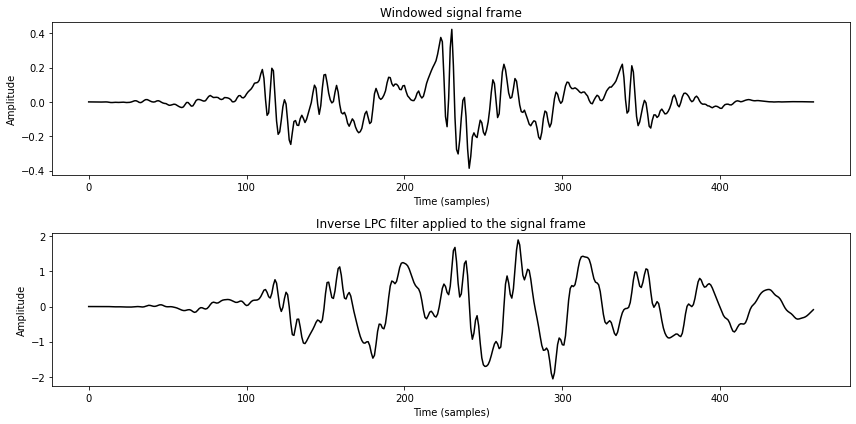

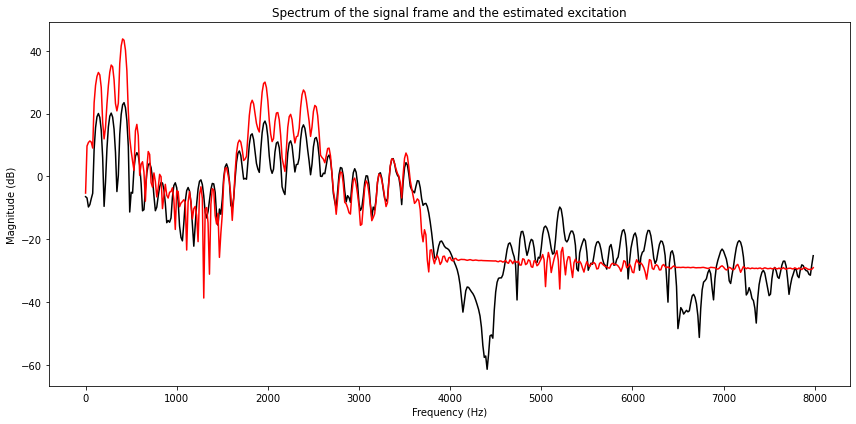

In [52]:
# magnitude spectrum
magP = np.abs(P)
ind_fmx = int(Ndft/2)

plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(s_win, 'k')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Windowed signal frame')
plt.tight_layout()
ax2 = plt.subplot(2, 1, 2)
plt.plot(p, 'k')
ax2.set_title('Inverse LPC filter applied to the signal frame')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time (samples)')
plt.tight_layout()


# plot the frequency response
plt.figure(figsize=(12,6))
ax1 = plt.subplot()
ax1.set_title('Spectrum of the signal frame and the estimated excitation')
ax1.plot(f[:ind_fmx], 20 * np.log10(magX[:ind_fmx]), 'k')
ax1.plot(f[:ind_fmx], 20 * np.log10(magP[:ind_fmx]), 'r')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_xlabel('Frequency (Hz)')
plt.tight_layout()
